<a href="https://colab.research.google.com/github/indluru-vishnuvardhanareddy/heart-disease-prediction/blob/main/isroweather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Install the netCDF4 library (if not already installed)
!pip install netCDF4
# Step 3: Load and read the .nc file
import netCDF4



Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Replace 'your_file.nc' with the path to your NetCDF file in Google Drive
file_path = '/content/drive/MyDrive/IMDAA_merged_1.08_1990_2020.nc'

ds=  xr.open_dataset(r'/content/drive/MyDrive/IMDAA_merged_1.08_1990_2020.nc')


# Print the dataset to understand its structure
print(ds)

<xarray.Dataset> Size: 742MB
Dimensions:   (time: 45292, latitude: 32, longitude: 32)
Coordinates:
  * time      (time) datetime64[ns] 362kB 1990-01-01 ... 2020-12-31T18:00:00
    lat       (latitude) float64 256B ...
    lon       (longitude) float64 256B ...
Dimensions without coordinates: latitude, longitude
Data variables:
    HGT_prl   (time, latitude, longitude) float32 186MB ...
    TMP_prl   (time, latitude, longitude) float32 186MB ...
    TMP_2m    (time, latitude, longitude) float32 186MB ...
    APCP_sfc  (time, latitude, longitude) float32 186MB ...
Attributes:
    CDI:                  Climate Data Interface version 1.9.8 (https://mpime...
    Conventions:          COARDS
    history:              Wed Jun 14 21:34:08 2023: cdo -f nc4c -z zip_4 copy...
    History:              created by wgrib2
    GRIB2_grid_template:  0
    CDO:                  Climate Data Operators version 1.9.8 (https://mpime...
    regrid_method:        bilinear


In [5]:
!pip install cartopy
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 95.0 MB/s eta 0:00:00


In [6]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

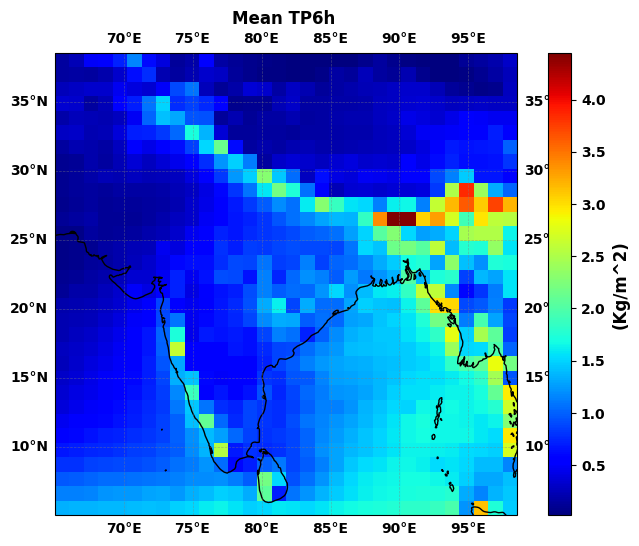

In [7]:
mean_all = ds.mean(dim='time')
z500 = mean_all
data_values = z500['APCP_sfc'].values

# Get the extent of your xarray dataset
lon_min, lon_max, lat_min, lat_max = z500.lon.min(), z500.lon.max(), z500.lat.min(), z500.lat.max()

# Create a basic plot within the extent of your xarray data using cartopy
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
im = ax.imshow(data_values, cmap='jet', origin='lower', extent=[lon_min, lon_max, lat_min, lat_max], transform=ccrs.PlateCarree())

ax.tick_params( labelcolor='black', labelsize='large', width=2)
# Add country borders and coastlines within the extent
ax.add_feature(cfeature.COASTLINE, linewidth=1)
#ax.add_feature(cfeature.BORDERS, linewidth=1)
#world.boundary.plot(ax=ax, linewidth=1, color='black')

# Add Cartopy graticules (latitude and longitude lines)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'color': 'black', 'weight': 'bold'}
gl.xlabel_style = {'color': 'black', 'weight': 'bold'}
#ax.set_xticks(range(int(lon_min), int(lon_max) + 1, 10), crs=ccrs.PlateCarree())
#ax.set_yticks(range(int(lat_min), int(lat_max) + 1, 10), crs=ccrs.PlateCarree())
# plt.xticks(fontweight='bold')
# plt.yticks(fontweight='bold')
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('(Kg/m^2)', fontsize = 12, weight="bold")
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), weight="bold")
plt.title('Mean TP6h ' , fontweight='bold')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.grid(True)
plt.savefig('TP6h.png', dpi = 600)
plt.show()

In [8]:
def compute_rmse(prediction, actual,  mean_dims = ('time', 'latitude', 'longitude')):
  error = prediction - actual
  rmse = np.sqrt(((error)**2 ).mean(mean_dims))
  return rmse

In [9]:
def compute_mae(prediction, actual, mean_dims = ('time', 'latitude', 'longitude')):
    error = prediction - actual
    mae = np.abs(error).mean(mean_dims)
    return mae

In [10]:
import numpy as np

def compute_r_squared(prediction, actual, mean_dims=('time', 'latitude', 'longitude')):
    # Calculate the sum of squares of residuals (SSR)
    ssr = np.square(prediction - actual).sum(mean_dims)

    # Calculate the total sum of squares (SST)
    sst = np.square(actual - actual.mean(mean_dims)).sum(mean_dims)

    # Calculate the R-squared value
    r_squared = 1 - (ssr / sst)

    return r_squared


In [11]:
def compute_acc(prediction, actual):
    clim = actual.mean('time')
    try:
        t = np.intersect1d(prediction.time, actual.time)
        pred_anomaly = prediction.sel(time=t) - clim
    except AttributeError:
        t = actual.time.values
        pred_anomaly = prediction - clim
    act_anomaly = actual.sel(time=t) - clim

    pred_norm = pred_anomaly - pred_anomaly.mean()
    act_norm = act_anomaly - act_anomaly.mean()

    acc = (
            np.sum(pred_norm * act_norm) /
            np.sqrt(
                np.sum(pred_norm ** 2) * np.sum(act_norm ** 2)
            )
    )
    return acc

In [12]:
# training dataset selection
train_years = slice('1990', '2017')
# validation dataset selection (this dataset helps with overfitting)
valid_years = slice('2018', '2018')
# test dataset selection
test_years = slice('2019', '2020')

In [13]:
var_name = ['HGT_prl', 'TMP_prl', 'TMP_2m', 'APCP_sfc']

# Each day the data has four observations at 00 UTC, 06 UTC, 12 UTC and 18 UTC
lead_time_steps = np.arange(4, 64, 4)
lead_time_steps

array([ 4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60])

In [14]:
import xarray as xr
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd

# Compute R-squared function
def compute_r_squared(prediction, actual):
    prediction_flat = prediction.values.ravel()
    actual_flat = actual.values.ravel()

    ssr = np.sum(np.square(prediction_flat - actual_flat))
    sst = np.sum(np.square(actual_flat - np.mean(actual_flat)))

    r_squared = 1 - (ssr / sst)
    return r_squared

# Load your dataset
ds = xr.open_dataset('/content/drive/MyDrive/IMDAA_merged_1.08_1990_2020.nc')

# Define your target latitude and longitude
target_latitude = 13.5
target_longitude = 80.0

# Nearest lat/lon index calculation
nearest_lat_index = np.argmin(np.abs(ds['lat'].values - target_latitude))
nearest_lon_index = np.argmin(np.abs(ds['lon'].values - target_longitude))

# Extract data for the nearest latitude and longitude for all variables
nearest_data = ds.isel(latitude=nearest_lat_index, longitude=nearest_lon_index)

# Define the list of variable names you're interested in
var_names = ['HGT_prl', 'TMP_prl', 'TMP_2m', 'APCP_sfc']

# Convert time to pandas datetime format if it's not already
nearest_data['time'] = pd.to_datetime(nearest_data['time'].values)

# Calculate the latest date in the dataset
end_date = nearest_data['time'].values[-1]
start_date = end_date - np.timedelta64(7, 'D')

# Initialize dictionaries to store results
r_squared_results = {}
mae_results = {}
rmse_results = {}

# Loop over each variable
for var_name in var_names:
    # Retrieve data between the start and end date
    prediction_variable = nearest_data[var_name].sel(time=slice(start_date, end_date))
    actual_variable = nearest_data[var_name].sel(time=slice(start_date, end_date))

    # Ensure prediction and actual data have the same shape
    if prediction_variable.shape != actual_variable.shape:
        min_length = min(prediction_variable.shape[0], actual_variable.shape[0])
        prediction_variable = prediction_variable.isel(time=slice(0, min_length))
        actual_variable = actual_variable.isel(time=slice(0, min_length))

    # Calculate R-squared
    r_squared = compute_r_squared(prediction_variable, actual_variable)

    # Calculate MAE
    mae = mean_absolute_error(actual_variable, prediction_variable)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual_variable, prediction_variable))

    # Store the results
    r_squared_results[var_name] = r_squared
    mae_results[var_name] = mae
    rmse_results[var_name] = rmse

# Print the results
for var_name in var_names:
    print(f"Results for {var_name}:")
    print(f"R-squared: {r_squared_results[var_name]}")
    print(f"MAE: {mae_results[var_name]}")
    print(f"RMSE: {rmse_results[var_name]}")
    print("\n")


Results for HGT_prl:
R-squared: 1.0
MAE: 0.0
RMSE: 0.0


Results for TMP_prl:
R-squared: 1.0
MAE: 0.0
RMSE: 0.0


Results for TMP_2m:
R-squared: 1.0
MAE: 0.0
RMSE: 0.0


Results for APCP_sfc:
R-squared: 1.0
MAE: 0.0
RMSE: 0.0




In [15]:
nearest_data['lat'].values

array(13.68)

In [16]:
nearest_data['lon'].values

array(80.16)

In [17]:
# Ensure 'time' is a coordinate in your xarray dataset
if 'time' not in nearest_data.coords:
    nearest_data = nearest_data.set_coords('time')

# Convert the nearest data to a DataFrame, keeping 'time' as a column
df = nearest_data.to_dataframe().reset_index()

# Now 'df' contains only the data for the nearest lat/lon with 'time' as a column



In [18]:
df.head()

,time,HGT_prl,lat,lon,TMP_prl,TMP_2m,APCP_sfc
0,1990-01-01 00:00:00,5851.058594,13.68,80.16,289.792603,298.783691,1.409983e-14
1,1990-01-01 06:00:00,5856.154785,13.68,80.16,288.841736,298.667847,2.255973e-13
2,1990-01-01 12:00:00,5853.154785,13.68,80.16,289.898529,299.045593,0.000000e+00
3,1990-01-01 18:00:00,5848.790039,13.68,80.16,288.813477,298.870850,0.000000e+00
4,1990-01-02 00:00:00,5851.955078,13.68,80.16,288.188904,299.142822,6.250000e-02


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45292 entries, 0 to 45291
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   time      45292 non-null  datetime64[ns]
 1   HGT_prl   45292 non-null  float32       
 2   lat       45292 non-null  float64       
 3   lon       45292 non-null  float64       
 4   TMP_prl   45292 non-null  float32       
 5   TMP_2m    45292 non-null  float32       
 6   APCP_sfc  45292 non-null  float32       
dtypes: datetime64[ns](1), float32(4), float64(2)
memory usage: 1.7 MB


In [20]:
# Ensure 'time' is a coordinate in your xarray dataset
if 'time' not in nearest_data:
    nearest_data = nearest_data.set_coords('time')

# Convert the nearest data to a DataFrame, keeping 'time' as a column
df = nearest_data.to_dataframe().reset_index() # Make sure to reset the index here

# Now 'df' contains only the data for the nearest lat/lon with 'time' as a column

df = df.set_index('time')  # Now you can set 'time' as index

# Use loc with string slicing for filtering
data_train = df.loc['1990':'2018']
data_test = df.loc['2019':'2020']
test_data = df.loc['2019':'2020']

In [21]:
data_mean = data_train.mean()
data_std = data_train.std()

In [22]:
data_std

,0
HGT_prl,1.838180e+01
lat,5.329133e-15
lon,0.000000e+00
TMP_prl,2.954468e+00
TMP_2m,1.965149e+00
APCP_sfc,5.753674e+00


In [23]:
data_train = (data_train - data_mean) / data_std
data_test = (data_test - data_mean) / data_std

In [24]:
nlat, nlon = data_train.HGT_prl.shape[0], 1  # Assuming 'HGT_prl' is 1D
print(nlat, nlon)

42368 1


In [25]:
data_train

,HGT_prl,lat,lon,TMP_prl,TMP_2m,APCP_sfc
time,,,,,,
1990-01-01 00:00:00,-0.698827,-0.999988,NaN,-1.078162,-1.204181,-0.157532
1990-01-01 06:00:00,-0.421586,-0.999988,NaN,-1.400002,-1.263130,-0.157532
1990-01-01 12:00:00,-0.584791,-0.999988,NaN,-1.042309,-1.070907,-0.157532
1990-01-01 18:00:00,-0.822240,-0.999988,NaN,-1.409567,-1.159829,-0.157532
1990-01-02 00:00:00,-0.650057,-0.999988,NaN,-1.620966,-1.021431,-0.146670
...,...,...,...,...,...,...
2018-12-30 18:00:00,1.314485,-0.999988,NaN,-2.070704,-1.289328,-0.157532
2018-12-31 00:00:00,1.260083,-0.999988,NaN,-2.763366,-1.315977,-0.157532
2018-12-31 06:00:00,1.504890,-0.999988,NaN,-2.950884,-1.674690,-0.157532


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [27]:
def create_training_data(da, lead_time_h, return_valid_time=False):
    """Function to split input and output by lead time."""
    X = da.isel(time=slice(0, -lead_time_h))
    y = da.isel(time=slice(lead_time_h, None))
    valid_time = y.time
    if return_valid_time:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon), valid_time
    else:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon)

In [28]:
def train_lr(lead_time_h, input_vars, output_vars, data_subsample=1):
    """Create data, train a linear regression and return the predictions."""
    X_train, y_train, X_test, y_test = [], [], [], []
    for v in input_vars:
        X, y = create_training_data(
            data_train[v],
            lead_time_h
        )

        X_train.append(X)
        if v in output_vars: y_train.append(y)
        X, y, valid_time = create_training_data(data_test[v], lead_time_h, return_valid_time=True)
        X_test.append(X)
        if v in output_vars: y_test.append(y)
    X_train, y_train, X_test, y_test = [np.concatenate(d, 1) for d in [X_train, y_train, X_test, y_test]]


    X_train = X_train[::data_subsample]
    y_train = y_train[::data_subsample]


    lr = LinearRegression(n_jobs=16)
    lr.fit(X_train, y_train)

    mse_train = mean_squared_error(y_train, lr.predict(X_train))
    mse_test = mean_squared_error(y_test, lr.predict(X_test))
    print(f'Train MSE = {mse_train}'); print(f'Test MSE = {mse_test}')
    preds = lr.predict(X_test).reshape((-1, len(output_vars), nlat, nlon))


    fcs = []
    for i, v in enumerate(output_vars):
        fc = xr.DataArray(
            preds[:, i] * data_std[v].values + data_mean[v].values,
            dims=['time', 'latitude', 'longitude'],
            coords={
                'time': valid_time,
                'lat': data_train.lat,
                'lon': data_train.lon
            },
            name=v
        )
        fcs.append(fc)
    return xr.merge(fcs), lr

In [29]:
var_name = ['HGT_prl', 'TMP_prl', 'TMP_2m', 'APCP_sfc']

In [30]:
ds = df['TMP_prl']
ds

,TMP_prl
time,
1990-01-01 00:00:00,289.792603
1990-01-01 06:00:00,288.841736
1990-01-01 12:00:00,289.898529
1990-01-01 18:00:00,288.813477
1990-01-02 00:00:00,288.188904
...,...
2020-12-30 18:00:00,289.661072
2020-12-31 00:00:00,288.696533
2020-12-31 06:00:00,288.021820


In [31]:
experiments = [
    [['HGT_prl'], ['HGT_prl']],
    [['TMP_prl'], ['TMP_prl']],
    # [['HGT_prl', 'TMP_prl'], ['HGT_prl', 'TMP_prl']],
    [['APCP_sfc'], ['APCP_sfc']],
    # [['HGT_prl', 'TMP_prl', 'APCP_sfc'], ['APCP_sfc']],
    [['TMP_2m'], ['TMP_2m']],
    # [['HGT_prl', 'TMP_prl', 'TMP_2m'], ['TMP_2m']],
]

In [32]:
# training dataset selection
train_years = slice('1990', '2017')
# validation dataset selection (this dataset helps with overfitting)
valid_years = slice('2018', '2018')
# test dataset selection
test_years = slice('2019', '2020')
# prediction days ahead
lead_time_steps = 20

In [50]:
import xarray as xr
import pandas as pd

def get_train_valid_test_dataset(lead_steps, data_array):
    # Ensure data_array is an xarray DataArray
    if not isinstance(data_array, xr.DataArray):
        raise ValueError("Data_array must be an xarray DataArray object.")

    # Split the dataset
    train_data = data_array.sel(time=train_years)
    valid_data = data_array.sel(time=valid_years)
    test_data = data_array.sel(time=test_years)

    # Ensure no empty slices
    if train_data.size == 0 or valid_data.size == 0 or test_data.size == 0:
        raise ValueError("One of the datasets is empty. Check your data and time selection.")

    # Here, continue with your operations like reshaping, normalizing, etc.
    # Placeholder for reshaping the arrays (adjust according to your needs)
    X_train, Y_train = train_data, train_data  # Adjust according to actual processing
    X_valid, Y_valid = valid_data, valid_data
    X_test, Y_test = test_data, test_data

    mean = X_train.mean()  # Placeholder for actual calculation
    std = X_train.std()  # Placeholder for actual calculation

    # Ensure the shapes are correct after processing
    if X_train.shape[0] != Y_train.shape[0] or X_valid.shape[0] != Y_valid.shape[0] or X_test.shape[0] != Y_test.shape[0]:
        raise ValueError("Mismatch between the number of samples in X and Y datasets after processing!")

    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std

# Assuming 'df' is your original DataFrame and it has a 'time' index
ds = df[['HGT_prl', 'TMP_prl', 'TMP_2m', 'APCP_sfc']]

# Convert DataFrame to xarray DataArray, specifying both dimensions
ds_xr = xr.DataArray(ds, dims=['time', 'variables'], coords={'time': ds.index, 'variables': ds.columns})

try:
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std = get_train_valid_test_dataset(lead_time_steps, ds_xr)

    # Check the shapes
    print(f"X_train shape: {X_train.shape}")
    print(f"Y_train shape: {Y_train.shape}")
    print(f"X_valid shape: {X_valid.shape}")
    print(f"Y_valid shape: {Y_valid.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"Y_test shape: {Y_test.shape}")

except ValueError as e:
    print(f"Error encountered: {e}")



X_train shape: (40908, 4)
Y_train shape: (40908, 4)
X_valid shape: (1460, 4)
Y_valid shape: (1460, 4)
X_test shape: (2924, 4)
Y_test shape: (2924, 4)


In [49]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(40908, 4)
(40908, 4)
(1460, 4)
(1460, 4)
(2924, 4)
(2924, 4)


In [51]:
import tensorflow.keras as keras
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, GRU, LSTMCell
from keras.layers import Conv2D, MaxPooling2D, Flatten, Bidirectional, LSTM, Dense, TimeDistributed, Conv1D, MaxPooling1D, Dropout, Conv3D
import warnings
warnings.filterwarnings('ignore')

In [52]:
model = keras.Sequential([
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    # keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.MaxPooling2D(),

    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.UpSampling2D(),
    # keras.layers.BatchNormalization(),

    keras.layers.Conv2D(1, 5, padding='same'),

    # No activation since we are solving a regression problem
])

In [53]:
import xarray as xr
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Convert X_train to a NumPy array and then reshape it
X_train_np = X_train.values  # Convert xarray.DataArray to NumPy array
X_train_reshaped = X_train_np.reshape((-1, 1, 1, 1))  # Assuming you want a single channel

# Clear the existing model session if any
keras.backend.clear_session()

# Recreate the model
model = keras.Sequential([
    keras.layers.Conv2D(32, 5, padding='same', activation='swish', input_shape=(1, 1, 1)),  # Define input shape here
    # ... (rest of your model layers)
])

# Compile the model - no need to build again
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='mse')
model.summary()

# Proceed with training the model if required


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1, 1, 32)            │             832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 832 (3.25 KB)

 Trainable params: 832 (3.25 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the file path to save the model
checkpoint_filepath = 'best_model.keras'  # Use the .keras extension

# Create ModelCheckpoint callback
checkpoint = ModelCheckpoint(checkpoint_filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

# You can also add an EarlyStopping callback if desired
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1,
                               mode='min',
                               restore_best_weights=True)

# Now you can pass these callbacks to the model's fit function


In [62]:
model = keras.Sequential([
    keras.layers.Conv2D(32, 5, padding='same', activation='swish', input_shape=(1, 1, X_train.shape[1])),  # (1, 1, 4)
    # Add more layers as needed
    keras.layers.Flatten(),
    keras.layers.Dense(1)  # Adjust this layer to match the shape of Y_train
])


In [87]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, Y_train)

RandomForestRegressor()

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(4)
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=20, batch_size=32)


Epoch 1/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9706 - loss: 1182040.7500
Epoch 2/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 9.9215
Epoch 3/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 1.0000 - loss: 8.7731
Epoch 4/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 6.5588
Epoch 5/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 1.0000 - loss: 5.7260
Epoch 6/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 1.0000 - loss: 6.1114
Epoch 7/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 1.0000 - loss: 6.2042
Epoch 8/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 1.0000 - loss: 6.3545
Epoch 9/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 6.5488
Epoch 10/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.0000 - loss: 6.7774
Epoch 11/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 1.0000 - loss: 6.1984
Epoch 12/20
1279/1279 ━━

In [85]:
import tensorflow.keras.backend as K

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(4)
])


model.compile(optimizer='adam', loss='mse', metrics=[r_square])
model.fit(X_train, Y_train, epochs=20, batch_size=32)

Epoch 1/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1268181.0000 - r_square: 0.7897
Epoch 2/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.1577 - r_square: 1.0000
Epoch 3/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.6090 - r_square: 1.0000
Epoch 4/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.4858 - r_square: 1.0000
Epoch 5/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.2473 - r_square: 1.0000
Epoch 6/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6058 - r_square: 1.0000
Epoch 7/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.3976 - r_square: 1.0000
Epoch 8/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3.3006 - r_square: 1.0000
Epoch 9/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3.4953 - r_square: 1.0000
Epoch 10/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.3107 - r_square: 1.0000
Epoch 11/20
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.4501 - r_square: 1.0000
Epoch 12/20
1279/1279 ━━

In [89]:
# Example shapes
print(X_train.shape)  # (number of samples, timesteps, number of features)
print(Y_train.shape)  # (number of samples, number of targets)


(40908, 4)
(40908, 4)


In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Reshape X_train to include a time dimension if necessary
# For example, if each sample has a single timestep:
X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])

# Ensure Y_valid also has the time dimension
# Assuming Y_valid needs the same reshaping as X_train:
Y_valid_reshaped = Y_valid.values.reshape(Y_valid.shape[0], 1, Y_valid.shape[1])

# Create the Keras model, using a different variable name
keras_model = Sequential([
    GRU(64, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dense(4, activation='sigmoid')  # Change the output dimension to 4
])

keras_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Use the reshaped Y_valid for validation
history = keras_model.fit(X_train_reshaped, Y_train, epochs=10, batch_size=32, validation_data=(X_valid, Y_valid_reshaped))

Epoch 1/10
1274/1279 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9331 - loss: -62619968.0000

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("IteratorGetNext:0", shape=(None, 4), dtype=float32). Expected shape (None, 1, 4), but input has incompatible shape (None, 4)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 4), dtype=float32)
  • training=False
  • mask=None